# Time Series Forecasting with the Long Short-Term Memory Network in Python
[Source](http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

In [1]:
import math
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense, LSTM
from tensorflow.contrib.keras.api.keras.callbacks import Callback

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Part 1: Show how each individual steps of the model behaves
IN this part we'll show how each individual steps behaves for the final model. The real implementation happens in Part 2

In [4]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('./shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

1-01
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
Name: 266.0, dtype: float64

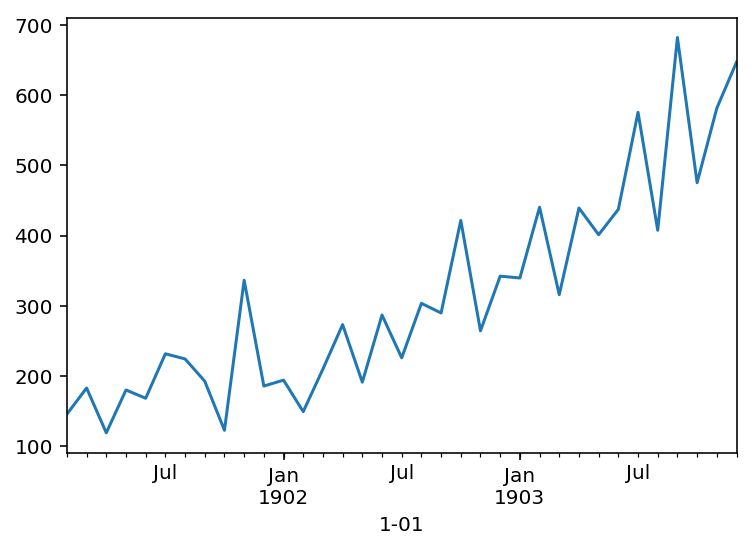

In [6]:
# line plot
series.plot();

In [18]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
print(len(X), len(train), len(test))

35 23 12


### Persistence Model Forecast
A good [**baseline forecast**](http://machinelearningmastery.com/persistence-time-series-forecasting-with-python/) for a time series with a linear increasing trend is a persistence forecast.
> A baseline in forecast performance provides a point of comparison.
>
> It is a point of reference for all other modeling techniques on your problem. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned.

In [21]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])

In [39]:
print(len(test), len(predictions))

12 12


In [51]:
pd.DataFrame({'0_test':test, '1_predictions':predictions}).head()

,0_test,1_predictions
0,339.7,342.3
1,440.4,339.7
2,315.9,440.4
3,439.3,315.9
4,401.3,439.3


RMSE: 136.761


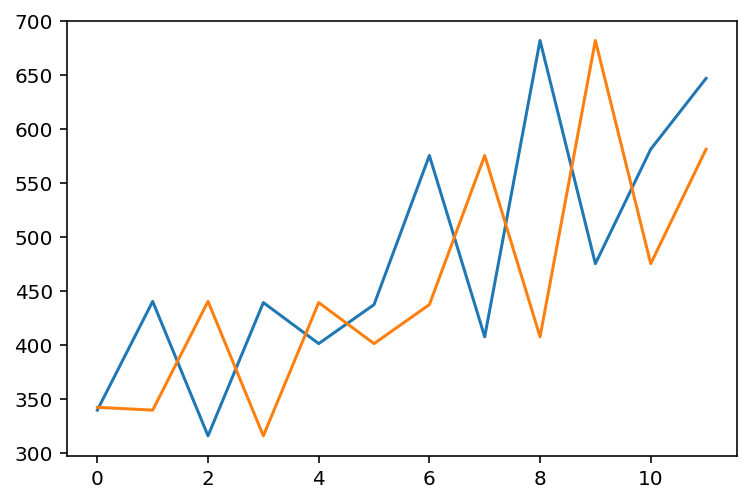

In [36]:
# report performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test) # blue
plt.plot(predictions); # orange

Here the RMSE is basically the "minimum error" our model could achieve when we'll compare this loss to our real model predictions

### Transform Time Series to Supervised Learning

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

### Transform Time Series to Stationary

The Shampoo Sales dataset is not stationary (there is a structure in the data which is dependent on the time).

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

Stationary data is easier to model and will very likely result in more skillful forecasts.

A standard way to remove a trend is by differencing the data.

   - [How to Check if Time Series Data is Stationary with Python](http://machinelearningmastery.com/time-series-data-stationary-python/)
   - [How to Difference a Time Series Dataset with Python](http://machinelearningmastery.com/difference-time-series-dataset-python/)

*Our goal here is to create 2 functions, 1 to transform the data into stationnary data and a second one to revert the process*

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by **_identifying and removing trends and removing seasonal effects._**

In [52]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [53]:
# transform to be stationary
differenced = difference(series, 1)
print("Transformed data:\n{}".format(differenced.head()))

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print("Reverted data:\n{}".format(inverted.head()))

Transformed data:
0    37.2
1   -63.8
2    61.0
3   -11.8
4    63.3
dtype: float64
Reverted data:
0    183.1
1    119.3
2    180.3
3    168.5
4    231.8
dtype: float64


In [67]:
df = pd.DataFrame({'original': history})
df['shift1'] = df.shift(-1)
df['difference'] = differenced
df['inverted'] = inverted
df

,original,shift1,difference,inverted
0,145.9,183.1,37.2,183.1
1,183.1,119.3,-63.8,119.3
2,119.3,180.3,61.0,180.3
3,180.3,168.5,-11.8,168.5
4,168.5,231.8,63.3,231.8
5,231.8,224.5,-7.3,224.5
6,224.5,192.8,-31.7,192.8
7,192.8,122.9,-69.9,122.9
8,122.9,336.5,213.6,336.5
9,336.5,185.9,-150.6,185.9


### Transform Time Series to Scale

LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [68]:
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print("Scaled data:{}".format(scaled_series.head()))
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print("Back to original data:{}".format(inverted_series.head()))

Scaled data:0   -0.905456
1   -0.773236
2   -1.000000
3   -0.783188
4   -0.825129
dtype: float64
Back to original data:0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


### LSTM Model Development

Once compiled, it can be fit to the training data. Because the network is stateful, we must control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs.

In [69]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False)
        model.reset_states()
    return model

### LSTM Forecast

We can decide to fit the model once on all of the training data, then predict each new time step one at a time from the test data (we’ll call this the **fixed approach**), or we can re-fit the model or update the model each time step of the test data as new observations from the test data are made available (we’ll call this the **dynamic approach**).

Here we'll use the fixed approach.

In [70]:
def forecast(model, batch_size, row):
    X = row[0:-1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

## Part 2: Final Model

The preceding steps shown how each step behaves. We will now rewrite them all down here.

These steps includes:

 - Load the dataset from CSV file.
 - Transform the dataset to make it suitable for the LSTM model, including:
     - Transforming the data to a supervised learning problem.
     - Transforming the data to be stationary.
     - Transforming the data so that it has the scale -1 to 1.
 - Fitting a stateful LSTM network model to the training data.
 - Evaluating the static LSTM model on the test data.
 - Report the performance of the forecasts.

Define hyperparameters

In [ ]:
batch_size = 1
epochs = 2
neurons = 1

In [ ]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# load dataset
series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, batch_size, epochs, neurons)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=batch_size)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = math.sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-12:], label='Real values')
plt.plot(predictions, label='Predicted values')
plt.legend();